In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('personality_grades.csv')
del data['index']
del data['Name']

x = data.copy()
y = x.pop('Grade')

print(len(data), 'students in this dataset')

82 students in this dataset


In [3]:
# Personality traits (gathered from an assignment),
# and GPA

x.columns

Index(['Honesty-Humility', 'Sincerity', 'Fairness', 'Greed Avoidance',
       'Modesty', 'Emotionality', 'Fearfulness', 'Anxiety', 'Dependence',
       'Sentimentality', 'Extraversion', 'Social self-esteem',
       'Social boldness', 'Sociability', 'Liveliness', 'Agreeableness',
       'Forgivingness', 'Gentleness', 'Flexibility', 'Patience',
       'Conscientiousness', 'Organization', 'Diligence', 'Perfectionism',
       'Prudence', 'Openness to experience', 'Aesthetic appreciation',
       'Inquisitiveness', 'Unconventionality', 'Altruism', 'GPA'],
      dtype='object')

In [214]:
# Classification

# An "A" grade is 1, else 0.
y2 = np.where(y > 90, 1, 0)

# "D" or lower is 1, else 0.
y3 = np.where(y < 70, 1, 0)

In [217]:
pl = make_pipeline(
     MinMaxScaler(),
     ElasticNetCV(l1_ratio=0.3,
                  tol=0.01))

-cross_val_score(pl, x, y, cv=20,
                 scoring='neg_mean_absolute_error').mean()

8.5120296904904471

The model predicts a students' grade within 7 points on average. Not bad for a tiny sample size!

Now, what about classifications?

In [208]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100)

print('A students:')
print(cross_val_score(clf, x, y2, cv=10, scoring='accuracy').mean())
print()
print('Failing students:')
print(cross_val_score(clf, x, y3, cv=10, scoring='accuracy').mean())

A students:
0.8525

Failing students:
0.77


Good, not great. This is a newer model I'm trying and it will see further refinement next semester.

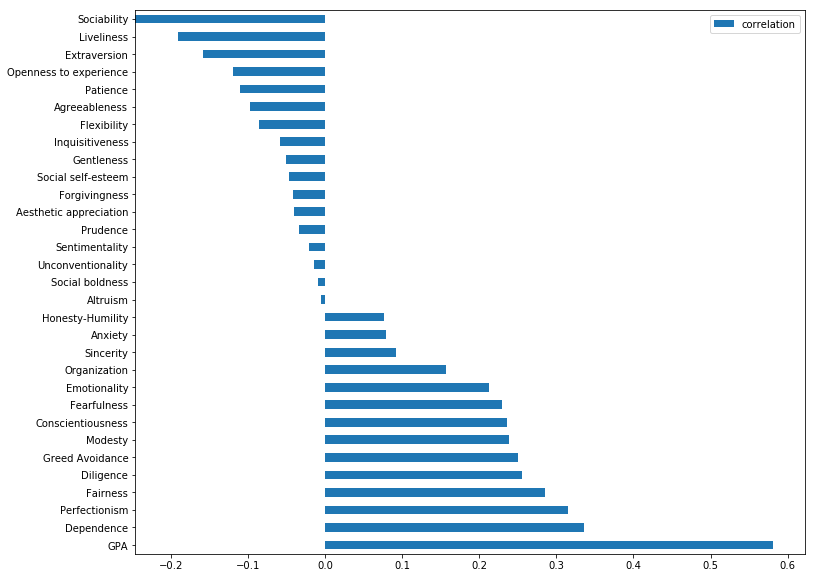

In [24]:
def absolute_correlations(col, df=data):
    corrs = pd.DataFrame(df.corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop(
        'absol', axis=1).tail(len(corrs)-1)

absolute_correlations('Grade')\
.sort_values('correlation', ascending=False)\
.plot.barh(figsize=(12, 10))

GPA, naturally, is the best predictor. I'm a behaviorist at heart; I believe the best way to predict future behavior is to look at past behavior.

# Model Performance

In [222]:
# Fit model and predict scores
pl.fit(x,y)
predicted = pl.predict(x)

In [223]:
results = pd.DataFrame()

results['grade'] = data['Grade']
results['pred'] = predicted
results['error'] = results['grade'] - results['pred']

absolute_error = np.abs(results['error'])

In [224]:
# Average error
absolute_error.mean()

6.350674906157597

In [225]:
#Sort by error
results = results.sort_values('error', ascending=False)

In [226]:
# Students that over-performed
results.head(10)

,grade,pred,error
66,95.75,81.416471,14.333529
71,95.12,81.369860,13.750140
61,88.12,74.659823,13.460177
37,86.08,72.711842,13.368158
63,86.21,73.065214,13.144786
70,87.29,75.796621,11.493379
52,89.62,78.394711,11.225289
77,89.37,78.892537,10.477463
23,96.37,86.085839,10.284161
42,78.92,70.031217,8.888783


In [227]:
# Students that under-performed
results.tail(10)

,grade,pred,error
29,63.00,72.653089,-9.653089
4,65.57,76.345813,-10.775813
25,44.12,56.447256,-12.327256
16,60.21,74.223014,-14.013014
12,50.37,65.481028,-15.111028
1,39.92,56.506972,-16.586972
80,56.00,77.604007,-21.604007
45,48.79,72.349489,-23.559489
38,48.29,72.133296,-23.843296
58,50.75,76.181314,-25.431314


# Version 2

In [4]:
data2 = pd.read_csv('personality_grades2.csv')
del data2['Name']

# Clean up column text
data2['About_1'] = data2['About_1'].str.strip()
data2['About_1'] = data2['About_1'].str.replace('\n', ' ')
data2['About_1'] = data2['About_1'].fillna(' ')

data2['About_2'] = data2['About_2'].str.strip()
data2['About_2'] = data2['About_2'].str.replace('\n', ' ')
data2['About_2'] = data2['About_2'].fillna(' ')

# Create tokens for missing entries
data2['About_1'].fillna(' ', inplace=True)
data2['About_2'].fillna(' ', inplace=True)

y = data2['Grade']

In [12]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

x = data.drop('Grade', axis=1)
y = data['Grade']

dum = DummyRegressor(strategy='median').fit(x,y)
-cross_val_score(dum,x,y,cv=10, scoring='neg_mean_absolute_error').mean()

9.9697222222222255

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=1, max_df=0.8)

text1 = tfidf.fit_transform(data2['About_1']).todense()
text2 = tfidf.fit_transform(data2['About_2']).todense()

text1 = pd.DataFrame(text1,
                    columns=['a_' + str(i) for i in range(text1.shape[1])])
text2 = pd.DataFrame(text2,
                    columns=['b_' + str(i) for i in range(text2.shape[1])])

data2 = pd.concat([data2, text1, text2], axis=1)

#del data2['About_1']
#del data2['About_2']

In [14]:
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, BayesianRidge

tfidf = TfidfVectorizer(max_df=0.1)
#x = data2.copy()
x = data2['About_1'].map(str) + data2['About_2']
y = data2['Grade']

reg = XGBRegressor(n_estimators=500)
reg2 = LinearRegression()

pl = make_pipeline(tfidf, reg2)

-cross_val_score(pl, x, y, cv=10,
                 scoring='neg_mean_absolute_error').mean()

9.7636179363356543

In [51]:
data2.columns

Index(['About_1', 'About_2', 'Grade', 'Honesty-Humility', 'Sincerity',
       'Fairness', 'Greed Avoidance', 'Modesty', 'Emotionality', 'Fearfulness',
       'Anxiety', 'Dependence', 'Sentimentality', 'Extraversion',
       'Social self-esteem', 'Social boldness', 'Sociability', 'Liveliness',
       'Agreeableness', 'Forgivingness', 'Gentleness', 'Flexibility',
       'Patience', 'Conscientiousness', 'Organization', 'Diligence',
       'Perfectionism', 'Prudence', 'Openness to experience',
       'Aesthetic appreciation', 'Inquisitiveness', 'Unconventionality',
       'Altruism', 'GPA'],
      dtype='object')